In [14]:
import sklearn
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import joblib
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

def evaluate_model(y_test, y_pred):
    print("Mean absolute error:\t", int(mean_absolute_error(y_test, y_pred)))
    print("Mean squared error:\t", int(mean_squared_error(y_test, y_pred)))

In [30]:
conn = sqlite3.connect('../db.sqlite3')
df_raw = pd.read_sql_query('''
SELECT "bouwjaar", "kilometer_stand", "vermogen", "prijs", "is_handgeschakeld", "is_benzine", "titel" 
FROM scraper_auto  
WHERE prijs < 15000 AND prijs > 900
''', conn)
df = df_raw.dropna()
df.describe()

,bouwjaar,kilometer_stand,vermogen,prijs,is_handgeschakeld,is_benzine
count,1081.000000,1.081000e+03,1081.000000,1081.000000,1081.000000,1081.000000
mean,2009.848289,1.636123e+05,83.553191,3791.274746,0.977798,0.591119
std,2.975380,9.946025e+04,13.243628,2325.968541,0.147407,0.491855
min,2005.000000,7.183000e+03,51.000000,944.000000,0.000000,0.000000
25%,2007.000000,1.148310e+05,77.000000,2350.000000,1.000000,0.000000
50%,2010.000000,1.653300e+05,84.000000,2950.000000,1.000000,1.000000
75%,2011.000000,2.067120e+05,86.000000,4450.000000,1.000000,1.000000
max,2018.000000,2.625966e+06,180.000000,13900.000000,1.000000,1.000000


In [31]:
df_train, df_test = train_test_split(df, test_size=0.2)

X_train = df_train.drop(['prijs'], axis=1)
y_train = df_train[['prijs']]

X_test = df_test.drop(['prijs'], axis=1)
y_test = df_test[['prijs']]['prijs']
X_test

,bouwjaar,kilometer_stand,vermogen,is_handgeschakeld,is_benzine,titel
1010,2015,126148.0,101,1.0,1,"Fiat Punto Evo 0.9 TwinAir Street met Airco, C..."
128,2006,183491.0,97,1.0,1,Fiat Grande Punto 1.416V Sport #Airco # 6 Bak....
153,2009,174900.0,65,1.0,1,Fiat Grande Punto 1.2 Active MET KETTINGMOTOR...
586,2011,221214.0,84,1.0,0,Fiat Punto Evo1.3 MJet Dynamic Kan direct mee.
799,2014,102984.0,101,1.0,1,Fiat Punto Evo 0.9 TwinAir Street Airco Cruise...
...,...,...,...,...,...,...
831,2006,217157.0,95,1.0,1,Fiat Grande Punto 1.416V Emotion top onderhoud...
941,2009,210850.0,120,1.0,1,"Fiat Grande Punto 1.4 16V Turbo 3DR 2009 Wit, ..."
241,2011,128000.0,84,1.0,0,Fiat Punto
695,2006,262250.0,120,1.0,0,Fiat Grande Punto 1.9 JTD Emotion EURO4(EXPORT...


In [32]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, ['bouwjaar', "kilometer_stand", "vermogen"]),
        ('text',  CountVectorizer(), 'titel')
    ],
    remainder='passthrough')

In [33]:
pipelines = []
pipelines.append(('DecisionTreeRegressor      ', Pipeline([('preprocessor', preprocessor),('LR', DecisionTreeRegressor())])))
pipelines.append(('Lasso                      ', Pipeline([('preprocessor', preprocessor),('LASSO', Lasso())])))
pipelines.append(('ElasticNet                 ', Pipeline([('preprocessor', preprocessor),('EN', ElasticNet())])))
pipelines.append(('KNeighborsRegressor        ', Pipeline([('preprocessor', preprocessor),('KNN', KNeighborsRegressor())])))
pipelines.append(('DecisionTreeRegressor      ', Pipeline([('preprocessor', preprocessor),('CART', DecisionTreeRegressor())])))
pipelines.append(('GradientBoostingRegressor  ', Pipeline([('preprocessor', preprocessor),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %i (%i)" % (name, abs(cv_results.mean()), cv_results.std())
    print(msg)

DecisionTreeRegressor      : 628 (67)
Lasso                      : 668 (118)
ElasticNet                 : 847 (93)
KNeighborsRegressor        : 645 (57)
DecisionTreeRegressor      : 636 (59)
GradientBoostingRegressor  : 476 (44)


In [34]:
param_grid = {
    'preprocessor__numeric__imputer__strategy': ['mean', 'median', 'constant'],
    'preprocessor__text__ngram_range': [(1,1), (1,2), (1,3)],
#     'classifier__loss': ['ls', 'lad', 'huber', 'quantile'],
#     'classifier__learning_rate': np.arange(0, 0.5, 0.1)
}

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingRegressor(loss='huber', learning_rate=0.1))
])

grid_search = GridSearchCV(clf, 
                           param_grid, 
                           cv=3,
                           scoring='neg_mean_absolute_error'
)

grid_search.fit(X_train, y_train)

print(("Best result: %.3f" % abs(grid_search.score(X_test, y_test))))

grid_search.best_params_

Best result: 504.748


{'preprocessor__numeric__imputer__strategy': 'constant',
 'preprocessor__text__ngram_range': (1, 2)}

In [35]:
y_pred = grid_search.best_estimator_.predict(X_test)
evaluate_model(y_test, y_pred)

Mean absolute error:	 504
Mean squared error:	 451026


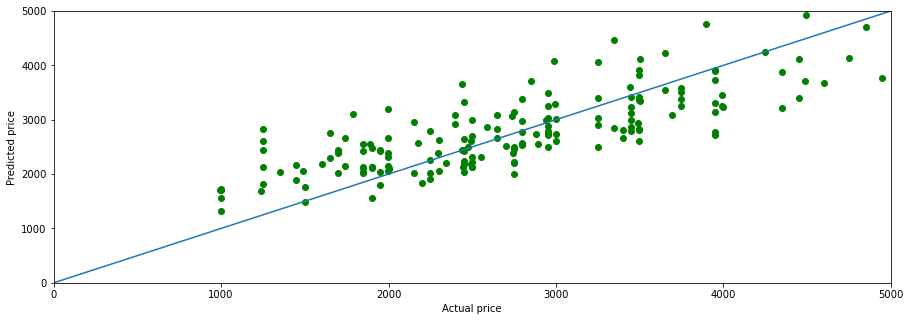

In [36]:
plt.figure(figsize=(15,5))
plt.scatter(y_test,y_pred,c='green')
plt.plot([0,5000], [0,5000])
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.xlim(0, 5000)
plt.ylim(0, 5000)
plt.show()

In [37]:
joblib.dump(grid_search.best_estimator_, 'Regressor')

['Regressor']